In [3]:
from brian2 import * 
import matplotlib.pyplot as plt 
import numpy as np 

In [92]:
def get_step_current(t_start, t_end,total_length, unit_time, amplitude, append_zero=True):


    assert isinstance(t_start, int), "t_start_ms must be of type int"
    assert isinstance(t_end, int), "t_end must be of type int"
    assert units.fundamentalunits.have_same_dimensions(amplitude, amp), \
        "amplitude must have the dimension of current e.g. brian2.uamp"
    tmp_size = total_length/unit_time  # +1 for t=0
    if append_zero:
        tmp_size += 1
    tmp = np.zeros((int(tmp_size), 1)) * amp
    tmp[int(t_start/unit_time): int(t_end/unit_time) + 1, 0] = amplitude
    curr = TimedArray(tmp, dt=1. * unit_time*ms)
    return curr

def OU_test(mu,dt,tau,sigma,unit,total_t):
    mu = mu
    dt = dt
    tau =tau
    sigma = sigma
    np.random.seed(0)
    time = np.arange(0,total_t,dt)
    x = np.zeros((len(time),1))
    x[0,0] =1

    for i in range(1,len(time)):
        # x[0,i] = x[0,i-1]+th*(mu-x[0,i-1])*dt+sig*sqrt(dt)*np.random.randn()
        x[i,0] = mu+((x[i-1,0]-mu)*np.exp(-dt/tau))+sigma*np.sqrt(1-np.exp(-2*dt/tau))*np.random.normal()
    # plt.plot(x[0])
    curr = TimedArray(x*unit, dt=dt*ms)
    return curr

def sim(ax_vm, parameters,input_current,plot=True):
    """
    simulate with parameters and plot to axes
    """

    # taken from Touboul_Brette_2008
    eqs = """
    i_stim = input_current(t,i):amp
    dvm/dt = (g_l*(e_l - vm) + g_l*d_t*exp((vm-v_t)/d_t) + i_stim - w)/c_m : volt
    dw/dt  = (a*(vm - e_l) - w)/tau_w : amp
    """

    neuron = NeuronGroup(
        1,
        model=eqs,
        threshold="vm > 0*mV",
        reset="vm = v_r; w += b",
        method="euler",
        namespace=parameters,
    )

    neuron.vm = parameters["e_l"]
    neuron.w = 0
    neuron.namespace["input_current"] = input_current

    states = StateMonitor(neuron, ["vm", "w"], record=True, when="thresholds")
    spikes = SpikeMonitor(neuron)
    defaultclock.dt = parameters['dt']
    run(parameters['runtime'] )

    # clip membrane voltages to threshold (0 mV)
    vms = np.clip(states[0].vm / mV, a_min=None, a_max=0)
    if plot:
        ax_vm.plot(states[0].t / ms, vms)
        ax_vm.scatter(int(spikes.t[:]/ms)*20,(states[0].t / ms)[int(spikes.t[:]/ms)*20])
        # ax_w.plot(states[0].t / ms, states[0].w / nA)
        # ax_vm_w.plot(vms, states[0].w / nA)

        # ax_w.sharex(ax_vm)
        # ax_vm.tick_params(labelbottom=False)

        ax_vm.set_ylabel("V [mV]")

        # ax_w.set_xlabel("t [ms]")
        # ax_w.set_ylabel("w [nA]")

        # ax_vm_w.set_xlabel("V [mV]")
        # ax_vm_w.set_ylabel("w [nA]")

        # ax_vm_w.yaxis.tick_right()
        # ax_vm_w.yaxis.set_label_position("right")
    return spikes.t[:]


In [4]:
#@title functions
def loadmat_(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
#     try:
    if ('analyzed' in filename )and ('_CC_' not in filename):
        Data = []
        data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)['Data']
        try:
            for i in range(len(data)):
                data_ = data[i]
                data_ = _todict(data_)
                Data.append(_check_keys(data_))
            return Data
        except:
            data_ = data
            data_ = _todict(data_)
            Data.append(_check_keys(data_))
            return Data
    elif ('analyzed' in filename) and ('_CC_' in filename):
        data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
        data = _todict(data)
    else:
        data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)['Data']
        data = _todict(data)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mat_struct):
            dict[key] = _todict(dict[key])
    return dict

def _todict(matobj):
    '''
    A recursive function which constructs nested dictionaries from matobjects
    '''
    dict = {}
    try:
      for strg in matobj._fieldnames:
          elem = matobj.__dict__[strg]
          if isinstance(elem, spio.matlab.mat_struct):
              dict[strg] = _todict(elem)
          elif strg =='Analysis':
              temp = []
              for i in elem:

                  temp.append(_todict(i))
              dict['Analysis'] = temp
          else:

              dict[strg] = elem
    except:
        for strg in matobj.keys():
          elem = matobj[strg]
          if isinstance(elem, spio.matlab.mat_struct):
              dict[strg] = _todict(elem)
          elif strg =='Analysis':
              temp = []
              for i in elem:

                  temp.append(_todict(i))
              dict['Analysis'] = temp
          else:

              dict[strg] = elem
    return dict

In [27]:
dat = loadmat_("D:/CurrentClamp/FN_analyzed/170704_NC_44_FN_analyzed.mat")
I = dat[0]['input_current']

In [89]:
import scipy.io as spio
def return_data_I(path):
    '''
    Loads the data from a single data file and returns input current

    args-
    path: path to the file
    '''
    dat = loadmat_(path)
    I = dat[0]['input_current']
    np.expand_dims(I,1)
    V = dat[0]['membrane_potential']
    unit_time = 1/20. * ms
    unit = pA
    tmp = np.expand_dims(I[:int(50000*20)]*5,1)*unit
    curr = TimedArray(tmp, dt=1. * unit_time)
    input_current = curr
    return input_current

In [45]:
I = return_data_I("D:/CurrentClamp/FN_analyzed/170704_NC_44_FN_analyzed.mat")

TypeError: only length-1 arrays can be converted to Python scalars

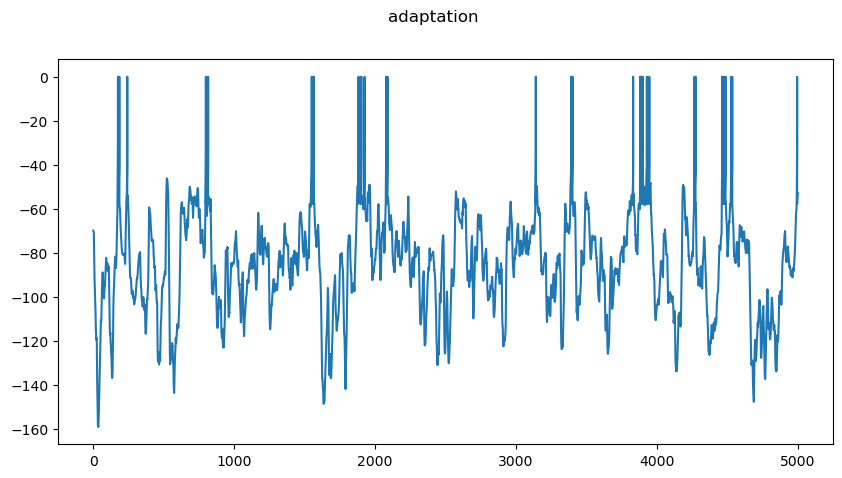

In [94]:

patterns = {
    "adaptation": {
        "c_m": 200 * pF,
        "g_l": 12 * nS,
        "e_l": -70.0 * mV,
        "v_t": -50.0 * mV,
        "d_t": 2.0 * mV,
        "a": 2.0 * nS,
        "tau_w": 300.0 * ms,
        "b": 60.0 * pA,
        "v_r": -58.0 * mV,
        "i_stim": 500 * pA,
        "dt":1/20*ms,
        "runtime":5*second
}}
all_spikes = []
# for i in np.arange(50,1000,50):
for pattern, parameters in patterns.items():

    fig = plt.figure(figsize=(10, 5))
    fig.suptitle(pattern)
    # gs = fig.add_gridspec(2, 2)

    ax_vm = fig.add_subplot()
    # ax_w = fig.add_subplot(gs[1, 0])
    # ax_vm_w = fig.add_subplot(gs[:, 1])
    # I = OU_test(500,0.1,30,300,pA,600)
    # I = get_step_current(50, 250, 600, 0.1, 40*pA)
    I = return_data_I("D:/CurrentClamp/FN_analyzed/170704_NC_44_FN_analyzed.mat")
    spikes = sim(ax_vm, parameters,I,plot=True)
    all_spikes.append(spikes)
# plt.show()


Text(0, 0.5, 'Firing rate(Hz)')

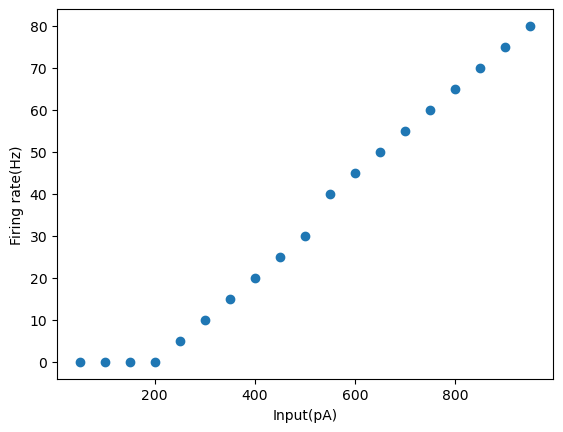

In [65]:
frs = []
for i in all_spikes:
    frs.append(len(i)/200)

plt.scatter(np.arange(50,1000,50),np.array(frs)*1000)
plt.xlabel('Input(pA)')
plt.ylabel('Firing rate(Hz)')

In [79]:
def get_STA(I,spikes):

    
    spk_ind = spikes
    # h = data_c1[0]['hidden_state']
    # spk_ind = data_c1[0]['spikeindices']
    sta = []

    TIME = 50*20
    for i in spk_ind:
        if i>TIME:
            sta.append(I[i-TIME:i,0])
    # plt.plot(np.arange(-50,0,1/20),np.array(sta)[:,:].T,c='grey',linewidth=0.2,alpha=0.3)
    plt.plot(np.arange(-50,0,1/20),np.mean(np.array(sta).T,axis=1),c='r',linewidth=4,alpha=0.5)

    plt.show()   


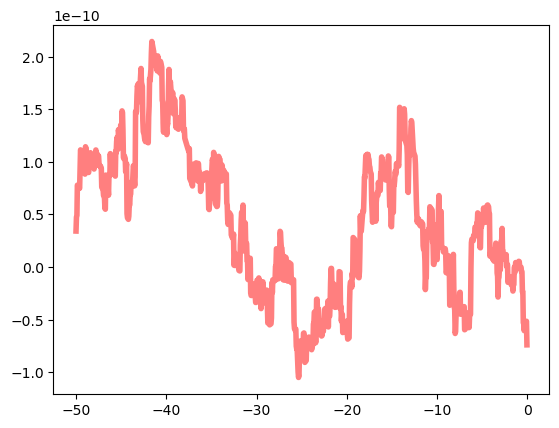

In [85]:
spks = np.array(spikes/ms*10,dtype=np.int32)
get_STA(I=I.values,spikes=spks)